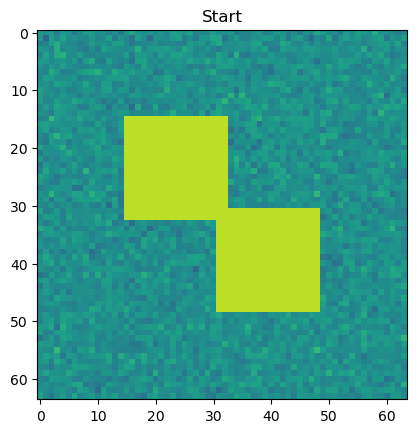

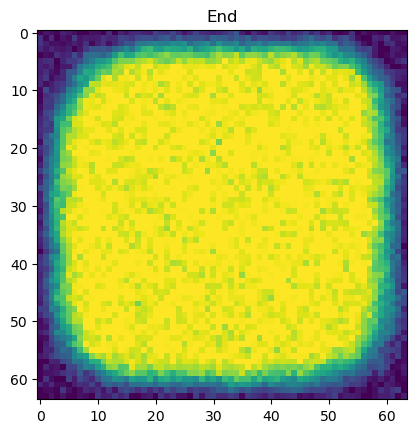

tboard/86981a1c-5faa-44bf-a0f8-19f39f0cb87c
CPU times: user 8.74 s, sys: 9.51 s, total: 18.2 s
Wall time: 15.7 s


In [2]:
%%time


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import dataclasses
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import uuid
from typing import Optional, TypedDict, Dict

import json

VMIN = 0.0
VMAX = 1.0

def get_img_array(tensor: torch.Tensor) -> np.ndarray:
    img = tensor.detach().cpu()
    if img.ndim == 2:
        return img.numpy()
    elif img.ndim == 3:
        return img.permute(1, 2, 0).numpy()
    else:
        raise RuntimeError(f"got {img.shape=}")

def plot_img(img: np.ndarray, title: str) -> None:
    plt.imshow(img, vmin=VMIN, vmax=VMAX)       
    plt.title(title)
    plt.show()


def plot_tensor(tensor: torch.Tensor, title: str):
    plot_img(img=get_img_array(tensor), title=title)


class TOutput(TypedDict):
    state: torch.Tensor
    other: Dict[str, torch.Tensor]

@dataclasses.dataclass
class SolverConfig:
    num_iters: int = 1000
    log_freq: int = 100


@dataclasses.dataclass
class Config:
    size: int
    diffusion_coefficient: float = 0.2
    growth_rate: float = 0.0
    noise_intensity: float = 0.2
    reversal_concentration: float = 0.9
    device: str = "cuda"


def compute_laplacian(x: torch.Tensor) -> torch.Tensor:
    padded_x = F.pad(x, (1, 1, 1, 1), mode='constant')  # Pad the input image
    size = x.shape[-1]
    laplacian = (
        padded_x[2:, 1:-1] + padded_x[:-2, 1:-1] +
        padded_x[1:-1, 2:] + padded_x[1:-1, :-2] - 4 * padded_x[1:-1, 1:-1]
    )
    return laplacian


class StochasticDE(nn.Module):
    size: int
    device: str
    def __init__(self, size: int, device: str):
        super().__init__()
        self.size = size
        self.device = device

    def init_state(self) -> torch.Tensor:
        state = (0.5 + self.noise_intensity * torch.randn(self.size, self.size, device=self.device)).clip(VMIN, VMAX)
        # state[self.size // 4: 3 * self.size // 4, self.size // 4: 3 * self.size // 4] = 0.9
        
        width = self.size // 7
        min_center = 3 * self.size // 8
        max_center = 5 * self.size // 8
        state[min_center - width: min_center + width, min_center - width: min_center + width] = 0.9
        state[max_center - width: max_center + width, max_center - width: max_center + width] = 0.9
        return state
    
    def forward(self, state: torch.Tensor, dt: float = 1.0) -> TOutput:
        ...

    def compute_reaction(self, state: torch.Tensor) -> torch.Tensor:
        ...


class V1(StochasticDE):
    def __init__(self, config: Config):
        super().__init__(size=config.size, device=config.device)
        self.diffusion_coefficient = config.diffusion_coefficient
        self.growth_rate = config.growth_rate
        self.noise_intensity = config.noise_intensity
        self.reversal_concentration = config.reversal_concentration

    def forward(self, state: torch.Tensor, dt: float = 1.0) -> TOutput:
        laplacian = self.diffusion_coefficient * compute_laplacian(state)
        reaction_term = self.growth_rate * self.compute_reaction(state)
        noise = torch.randn_like(state) * self.noise_intensity
        
        # Update the state
        grad = dt * (laplacian + reaction_term + noise)

        return {
            "state": (state + grad).clip(VMIN, VMAX),
            "other": {
                "laplacian": laplacian.detach(),
                "noise": noise.detach(),
                "reaction_term": reaction_term.detach(),
                "grad": grad.detach(),
            },
        }

    def compute_reaction(self, state: torch.Tensor) -> torch.Tensor:
        return state ** 2 - self.reversal_concentration


class V2(V1):    
    def compute_reaction(self, state: torch.Tensor) -> torch.Tensor:
        return state ** 2 - self.reversal_concentration


config = Config(
    size=64,
    diffusion_coefficient=0.2,
    growth_rate=0.025,
    noise_intensity=0.05,
    reversal_concentration=0.25,
    device="cuda",
)
solver_config = SolverConfig(num_iters=2500, log_freq=50)

logdir = f"tboard/{str(uuid.uuid4())}"
tb_logger = SummaryWriter(logdir)
tb_logger.add_text(
    "config", 
    json.dumps(
        {
            "project": "stochastic_fisher_kolmogorov",
            "config": dataclasses.asdict(config),
            "solver": dataclasses.asdict(solver_config),
        }, 
        indent=4,
    ),
)

model = V1(config)
state = model.init_state()
plot_tensor(state, "Start")
# Training loop
ctx = torch.no_grad()

ctx.__enter__()
for step in range(solver_config.num_iters):
    output = model(state)
    state = output["state"].detach()
    intermediates = output["other"]
    if tb_logger is not None:

        tb_logger.add_scalars(
            "intermediate", 
            {k: v.mean().cpu() for k, v in intermediates.items()},
            step,
        )
        
        tb_logger.add_scalars(
            "state_stats", 
            {
                "min": state.min().item(),
                "max": state.max().item(),
                "mean": state.mean().item(),
                "std": state.std().item(),
            },
            step,
        )

    if step % solver_config.log_freq == 0:
        tb_logger.add_image(
            "state",
            state.detach().cpu()[None, ...],
            global_step=step,
        )
        tb_logger.add_image(
            "laplacian",
            intermediates["laplacian"].detach().cpu()[None, ...],
            global_step=step,
        )
        # plot_tensor(state, f"{step=} {state.abs().mean().item()=}")

plot_tensor(state, "End")
ctx.__exit__(None, None, None)
print(logdir)

In [ ]:
# Example usage
config = Config(
    size=64,
    diffusion_coefficient=0.16,
    growth_rate=0.025,
    noise_intensity=0.05,
    reversal_concentration=0.25,
    device="cuda",
)
solver_config = SolverConfig(
    num_iters=250, 
    log_freq=20,
)
balanced_config = (config, solver_config)
